# ☕ TỐI ƯU HÓA MÔ HÌNH DỊCH CHO MIỀN DỮ LIỆU CÀ PHÊ (DOMAIN ADAPTATION)

---

### 🎯 Mục tiêu & Bối cảnh
Sau quá trình thử nghiệm so sánh (Model Selection), xác định **ViT5-base** là mô hình cân bằng tốt nhất giữa hiệu năng (BLEU score) và tốc độ suy luận.
Notebook này thực hiện bước **Fine-tuning lần 2 (Domain Adaptation)**:
* **Input Model:** Checkpoint ViT5-base đã được train trên tập dữ liệu chung (General 10k).
* **Dataset:** Tập dữ liệu chuyên ngành `Combined_Augmented_Coffee.csv` (bao gồm dữ liệu gốc + dữ liệu tăng cường bởi AI), tập trung vào các câu thoại gọi món, order đồ uống.

### 🚀 Quy trình thực hiện
1.  **Load Pre-trained Weights:** Tải trọng số từ lần fine-tune trước (`ViT5-base-time1`).
2.  **Data Preparation:**
    * Load tập dữ liệu Coffee đã được augmentation.
    * Thêm prefix `vi: ` và `vsl: ` để đồng nhất định dạng.
    * Chia tập Train/Val/Test (80/10/10).
3.  **Training:** Tiếp tục huấn luyện (Continue Training) với learning rate nhỏ (`1e-5`) để mô hình học thêm kiến thức miền (domain knowledge) mà không quên kiến thức cũ (catastrophic forgetting).
4.  **Evaluation:** Đánh giá kỹ lưỡng trên tập Test chuyên biệt về Cà phê để đảm bảo độ chính xác thực tế.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cài đặt thư việt cần thiết
!pip install -q transformers torch datasets accelerate gspread oauth2client pandas scikit-learn sacrebleu datasets evaluate jiwer matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 77.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.auth import default
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback
import numpy as np
import evaluate
import jiwer
import matplotlib.pyplot as plt

In [ ]:
# 1. Load mô hình và tokenizer đã fine-tune
model_path = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_base_time1/trained_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/Combined_Augmented_Coffee.csv')

In [ ]:
print("Cột trong csv: ", df.columns.tolist())
print("Số lượng cặp: ", len(df))
print("Ví dụ 5 dòng đầu: ")
print(df.head())

Cột trong csv:  ['vietnamese', 'vsl']
Số lượng cặp:  1691
Ví dụ 5 dòng đầu: 
                                          vietnamese  \
0                       Tôi muốn một ly sữa chua dâu   
1            Pha cho mình một nước ép thơm mát lạnh.   
2  Tôi muốn một ly cà phê sữa, ít đá, và thêm giấ...   
3  Cho Tôi một ly cà phê sữa, một ly nước ép cóc,...   
4                  Lấy cho Tôi một ly trà gừng nóng.   

                                               vsl  
0                        Tôi sữa chua dâu một muốn  
1                  mình nước ép thơm một lạnh muốn  
2            Tôi cà-phê sữa một đá ít giấy ăn muốn  
3  Tôi cà-phê sữa một nước ép cóc một giấy ăn muốn  
4                       Tôi trà gừng một nóng muốn  


In [ ]:
df['vietnamese'] = 'vi: ' + df['vietnamese'].astype(str)
df['vsl'] = 'vsl: ' + df['vsl'].astype(str)

In [ ]:
# Chia dữ liệu thành train/val/test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state = 42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state = 42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 1352, Val: 169, Test: 170


In [ ]:
# Chuyển sang Hugging Face Dataset
dataset ={
    'train': Dataset.from_pandas(train_df[['vietnamese', 'vsl']]),
    'val': Dataset.from_pandas(val_df[['vietnamese', 'vsl']]),
    'test': Dataset.from_pandas(test_df[['vietnamese', 'vsl']])
}

In [ ]:
# Hàm Tokenize dữ liệu
def preprocess_function(examples):
  inputs = examples['vietnamese']
  targets = examples['vsl']

  model_inputs = tokenizer(inputs, max_length = 128, truncation = True, padding = 'max_length')

  # Tokenize targets
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, max_length = 128, truncation = True, padding = 'max_length')

  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [ ]:
# Áp dụng tokenize cho Train, Test, Val
tokenized_datasets = {
    'train': dataset['train'].map(preprocess_function, batched = True),
    'val': dataset['val'].map(preprocess_function, batched = True),
    'test': dataset['test'].map(preprocess_function, batched = True)
}

Map:   0%|          | 0/1352 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

In [ ]:
# Định nghĩa Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_finetune_augmented_coffee/model_checkpoints',
    eval_strategy = 'epoch',
    learning_rate = 1e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    weight_decay = 0.01,
    save_total_limit = 3,
    num_train_epochs = 10,
    predict_with_generate = True, # to generate text when evaluate
    fp16 = True,
    logging_dir = '/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5_finetune_augmented_coffee/logs',
    logging_strategy = 'steps',
    logging_steps= 10,
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    report_to = 'none',
    metric_for_best_model = 'eval_loss',
    greater_is_better = False
)

In [ ]:
# Khởi tạo bộ tính toán bleu và wer
bleu_metric = evaluate.load('sacrebleu')
wer_metric = evaluate.load('wer')

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # In một vài giá trị preds để kiểm tra
    print("Sample preds: ", preds[:2]) # Lấy 2 mẫu đầu tiên

    # Làm sạch preds: Loại bỏ token IDs không hợp lệ
    vocab_size = tokenizer.vocab_size
    preds = np.where(preds < 0, tokenizer.pad_token_id, preds)
    preds = np.where(preds >= vocab_size, tokenizer.pad_token_id, preds)

    # Decode generated texts
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in labels (ignored tokens)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Chuẩn hóa text cho WER (loại bỏ dấu thừa, chuyển về lowercase)
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Compute BLEU
    bleu = bleu_metric.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])

    # Compute WER
    wer = jiwer.wer(decoded_labels, decoded_preds)

    return {
        "bleu": bleu["score"],
        "wer": wer
    }

In [ ]:
# Tránh token IDs không hợp lệ, cấu hình tham số generate
gen_kwargs = {
    'max_length': 128,
    'num_beams': 4,
    'no_repeat_ngram_size': 2
}

In [ ]:
# Tạo Trainer
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)]
)

/tmp/ipython-input-2948321485.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Huấn luyện Model
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Wer
1,0.065800,0.038228,66.424247,0.245370
2,0.035500,0.021880,74.906515,0.180556
3,0.026800,0.017081,77.258115,0.173611
4,0.022900,0.015269,79.073533,0.152006
5,0.024000,0.014229,80.182104,0.152006
6,0.018700,0.013477,80.817070,0.146605
7,0.016500,0.012702,82.371072,0.138889
8,0.013900,0.012081,82.630784,0.135031
9,0.016900,0.011892,84.616674,0.119599
10,0.016100,0.011729,83.728810,0.128086


Sample preds:  [[    0    11 11380 35862  1556  1700  6342  1090    68  1148     1     0
      0     0     0     0     0     0     0     0]
 [    0    11 11380 35862  1556  3237  6141  4237  8029  7427  7379  1056
   1148     1     0     0     0     0     0     0]]
Sample preds:  [[    0    11 11380 35862  1556  1700  6342  1090    68  1148     1     0
      0     0     0     0     0     0     0     0]
 [    0    11 11380 35862  1556  3237  6141  4237  8029  7427  7379  1056
   1148     1     0     0     0     0     0     0]]
Sample preds:  [[    0    11 11380 35862  1556  1700  6342  1090    68  1148     1     0
      0     0     0     0     0     0     0     0]
 [    0    11 11380 35862  1556  3237  6141  8828  1597  1056  1148     1
      0     0     0     0     0     0     0     0]]
Sample preds:  [[    0    11 11380 35862  1556  1700  6342  1090    68  1148     1     0
      0     0     0     0     0     0     0     0]
 [    0    11 11380 35862  1556  3237  6141 10284  1056  1148 

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=850, training_loss=0.032424092818708984, metrics={'train_runtime': 746.1285, 'train_samples_per_second': 18.12, 'train_steps_per_second': 1.139, 'total_flos': 2058277670092800.0, 'train_loss': 0.032424092818708984, 'epoch': 10.0})

In [ ]:
# Evaluating
test_results = trainer.evaluate(eval_dataset = tokenized_datasets['test'], **gen_kwargs)
print("Kết quả đánh giá trên test set: ", test_results)

Sample preds:  [[    0    11 11380 35862   651   246  8828   791  3055    15  2444    68
   1148     1     1     1     1     1     0     0]
 [    0    11 11380 35862  1556  7130  2188  5231    99  4594 35795    68
   1148     1     1     1     1     1     0     0]]
Kết quả đánh giá trên test set:  {'eval_loss': 0.011718850582838058, 'eval_bleu': 81.96854862256455, 'eval_wer': 0.13707165109034267, 'eval_runtime': 17.2205, 'eval_samples_per_second': 9.872, 'eval_steps_per_second': 0.639, 'epoch': 10.0}


In [ ]:
# Lấy log_history từ trainer.state
log_history = trainer.state.log_history

# Chuyển log_history thành DataFrame cho dễ xử lý
df_logs = pd.DataFrame(log_history)

# Tách log của training và evaluation
train_logs = df_logs[df_logs['loss'].notna()].reset_index(drop = True)
eval_logs = df_logs[df_logs['eval_loss'].notna()].reset_index(drop = True)

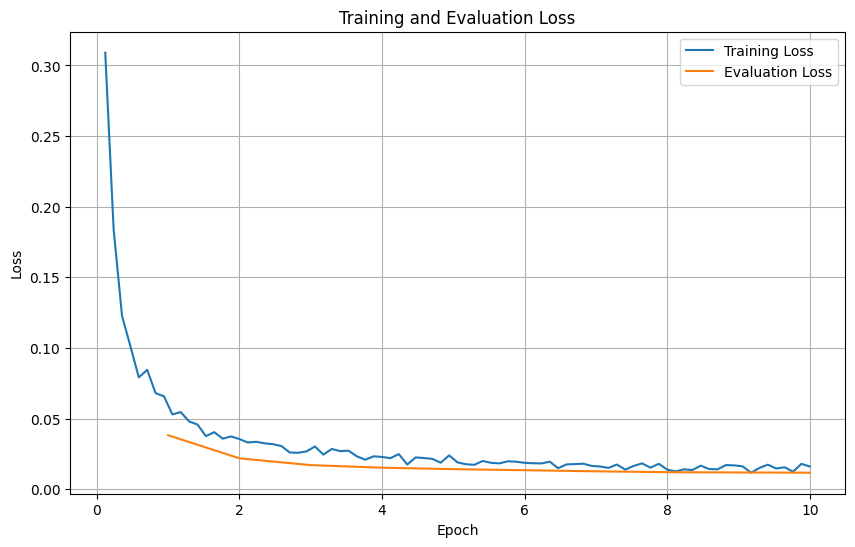

In [ ]:
# Vẽ đồ thị
plt.figure(figsize = (10, 6))
plt.plot(train_logs['epoch'], train_logs['loss'], label = 'Training Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label = 'Evaluation Loss')
plt.title('Training and Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Sử dụng model để thử dịch 2 câu tiếng Việt sang ngôn ngữ ký hiệu
# Câu tiếng Việt muốn dịch
sentence_to_translate = "Tôi muốn một ly nước ép cam."
prefix = "vsl:"
input_text = f"{prefix} {sentence_to_translate}"
print(f"Câu cần dịch: {input_text}")
inputs = tokenizer(input_text, return_tensors="pt").to('cuda')

Câu cần dịch: vsl: Tôi muốn một ly nước ép cam.


In [ ]:
with torch.no_grad():
    output_ids = model.generate(
        inputs["input_ids"],
        max_length=128,          # Độ dài tối đa của câu kết quả
        num_beams=5,             # Sử dụng beam search để kết quả tốt và mượt mà hơn
        early_stopping=True
    )

In [ ]:
# Giải mã
translated_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [ ]:
# In kết quả
print(f"Câu tiếng Việt gốc:\n'{sentence_to_translate}'")
print(f"\nNgôn ngữ ký hiệu:\n'{translated_sentence}'")

Câu tiếng Việt gốc:
'Tôi muốn một ly nước ép cam.'

Ngôn ngữ ký hiệu:
'vsl: Tôi nước ép cam một muốn'


In [ ]:
# 7. Lưu Model vào Drive
output_model_dir = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5-base/trained_model_augmented_coffee"
model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)
print(f"Model saved to {output_model_dir}")

Model saved to /content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5-base/trained_model_augmented_coffee


## Test Common Data

In [ ]:
!pip install -q transformers torch datasets accelerate pandas scikit-learn sacrebleu evaluate jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 64.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import torch
import numpy as np
import evaluate
import jiwer
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đường dẫn tới model bạn đã lưu ở bước cuối cùng của notebook trước
model_path = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/Models/ViT5-base/trained_model_augmented_coffee"

In [ ]:
test_data_path = "/content/drive/MyDrive/DUE - HỌC TẬP/YEAR 4 (2025-2026)/TTTN/raw_data/TestCoffee.csv"

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)

Using device: cuda


In [ ]:
# Đọc file CSV
df_test = pd.read_csv(test_data_path)

# QUAN TRỌNG: Phải thêm prefix giống hệt lúc train
# Lúc train bạn đã dùng: "vi: " + vietnamese và "vsl: " + vsl
df_test['vietnamese'] = 'vi: ' + df_test['vietnamese'].astype(str)
df_test['vsl'] = 'vsl: ' + df_test['vsl'].astype(str)

In [ ]:
# Chuyển sang Dataset của HuggingFace
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
# Hàm tokenize (giữ nguyên tham số như lúc train)
def preprocess_function(examples):
    inputs = examples['vietnamese']
    targets = examples['vsl']

    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding='max_length')

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding='max_length')

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [ ]:
# Tokenize tập test
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/107 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
bleu_metric = evaluate.load('sacrebleu')
wer_metric = evaluate.load('wer')

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Thay thế -100 (ignore index) bằng pad token để decode được
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Chuẩn hóa text
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Tính BLEU & WER
    bleu = bleu_metric.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])
    wer = jiwer.wer(decoded_labels, decoded_preds)

    return {"bleu": bleu["score"], "wer": wer}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./eval_results",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    fp16=True if device == "cuda" else False,
    report_to = 'none'
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-4130753477.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
print("\nStart evaluating...")
metrics = trainer.evaluate(eval_dataset=tokenized_test)


Start evaluating...


In [ ]:
print("\n" + "="*30)
print("KẾT QUẢ ĐÁNH GIÁ TRÊN TEST SET")
print("="*30)
print(f"Eval Loss: {metrics['eval_loss']:.4f}")
print(f"BLEU:      {metrics['eval_bleu']:.4f}")
print(f"WER:       {metrics['eval_wer']:.4f}")
print("="*30)


KẾT QUẢ ĐÁNH GIÁ TRÊN TEST SET
Eval Loss: 0.0045
BLEU:      95.7539
WER:       0.0272
